Genus 数量: 1117, embedding 维度: 256
taxonomy 文件中解析出的不同 Genus 数量: 1117

在 Family 层级上的不同类别数: 447
前几行预览：


,Genus,Count,Level
0,g__0319-6G20,362,f__0319-6G20
1,g__0319-7L14,35,f__0319-7L14
2,g__11-24,144,f__11-24
3,g__1174-901-12,61,f__Beijerinckiaceae
4,g__28-YEA-48,2,f__Beijerinckiaceae



在 Family 层级上，Top 20 类别为：


Level
f__Lachnospiraceae                        53
f__Comamonadaceae                         26
f__Chitinophagaceae                       23
f__Ruminococcaceae                        16
f__Sphingomonadaceae                      16
f__Erysipelotrichaceae                    15
f__Microbacteriaceae                      15
f__Micrococcaceae                         14
f__Peptostreptococcaceae                  13
f__Rhodocyclaceae                         12
f__Peptostreptococcales-Tissierellales    11
f__Oscillospiraceae                       11
f__Beijerinckiaceae                       11
f__Bacillaceae                            10
f__Planococcaceae                         10
f__Rhizobiaceae                           10
f__Acetobacteraceae                       10
f__Eggerthellaceae                        10
f__Prevotellaceae                          9
f__Moraxellaceae                           9
Name: count, dtype: int64


用于 UMAP 的点数: 304
不同 Level 数量: 20

开始 UMAP 降维 ...


/opt/micromamba/envs/MiCoSeq_dev_plot/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP 完成。


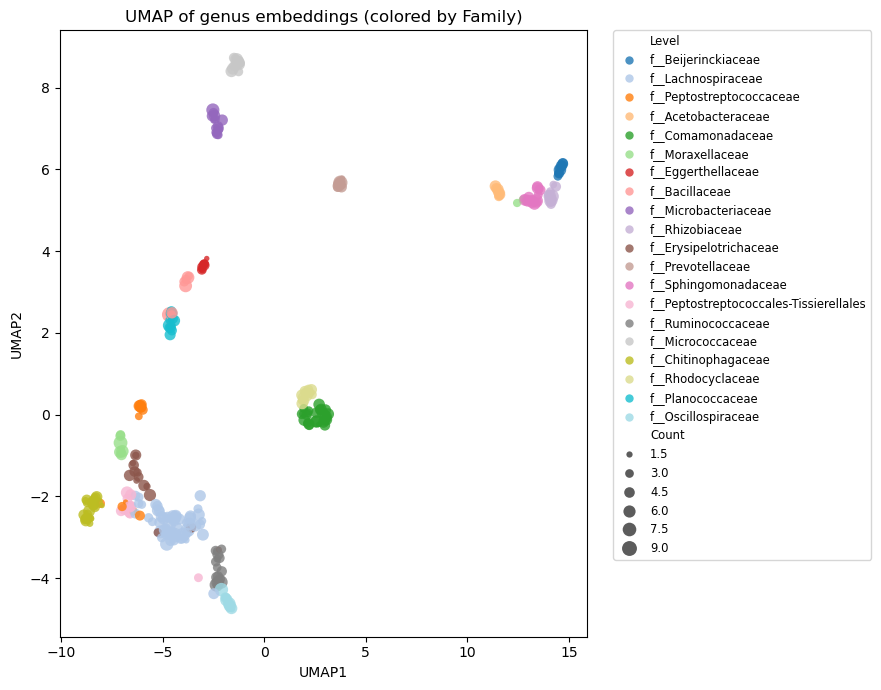


Top 类别与颜色对照表：


,Level,Color
0,f__Lachnospiraceae,#aec7e8
1,f__Comamonadaceae,#2ca02c
2,f__Chitinophagaceae,#bcbd22
3,f__Ruminococcaceae,#7f7f7f
4,f__Sphingomonadaceae,#e377c2
5,f__Erysipelotrichaceae,#8c564b
6,f__Microbacteriaceae,#9467bd
7,f__Micrococcaceae,#c7c7c7
8,f__Peptostreptococcaceae,#ff7f0e
9,f__Rhodocyclaceae,#dbdb8d


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import umap.umap_ as umap
from matplotlib.colors import to_hex
from tqdm import tqdm
import re
from typing import Optional

# =========================================
# 0. 配置区：你只需要改这里
# =========================================

GENUS_EMB_PATH = "genus_embeddings_256.npz"      # 之前保存的 genus-level embedding
TAXONOMY_CSV_PATH = "full_taxonomy.csv"      # 含有 Taxonomy 列的文件路径

# 选择要用来上色的层级：'Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species'
LEVEL = "Family"

# 是否只画 Top N（该层级出现频数最多的 N 个类群）
USE_TOP_N = True
TOP_N = 20

# 如果 USE_TOP_N = True：
#   - 如果 DROP_OTHERS = True：只画 TopN，其它类别完全不画
#   - 如果 DROP_OTHERS = False：TopN 用各自颜色，其它类别统一归为 "Others" 灰色
DROP_OTHERS = True

# UMAP 参数（可按需要调）
N_NEIGHBORS = 15
MIN_DIST = 0.1
RANDOM_STATE = 42
METRIC = "cosine"


# =========================================
# 1. 你的提取函数（用它来解析 Taxonomy）
# =========================================

RANK_PREFIX_MAP = {
    "Kingdom": "k__",
    "Phylum": "p__",
    "Class": "c__",
    "Order": "o__",
    "Family": "f__",
    "Genus": "g__",
    "Species": "s__",
}

def extract_taxon(raw_name: str, rank: str) -> Optional[str]:
    if rank not in RANK_PREFIX_MAP:
        raise ValueError(f"Unknown rank: {rank!r}.")

    name = str(raw_name).strip()
    name = name.replace("; ", ";")
    prefix = RANK_PREFIX_MAP[rank]
    pattern = rf"{re.escape(prefix)}[^;]*"
    m = re.search(pattern, name)
    if m:
        return m.group(0)
    print(f"[warning] Could not find {rank} (prefix {prefix!r}) in: {raw_name!r}")
    return None


# =========================================
# 2. 读取 genus-level embedding
# =========================================

data = np.load(GENUS_EMB_PATH, allow_pickle=True)
genus = data["genus"].astype(str)        # (G,)
embeddings = data["embeddings"]          # (G, 768)
counts = data["counts"]                  # (G,)

G, dim = embeddings.shape
print(f"Genus 数量: {G}, embedding 维度: {dim}")


# =========================================
# 3. 读取 taxonomy 文件，并用你的函数解析各个层级
# =========================================

tax_df = pd.read_csv(TAXONOMY_CSV_PATH)
if "Taxonomy" not in tax_df.columns:
    raise ValueError("taxonomy 文件中必须包含 'Taxonomy' 这一列。")

# 用你的函数提取 Genus 和目标层级
tax_df["Genus"] = tax_df["Taxonomy"].apply(lambda x: extract_taxon(x, "Genus"))
tax_df[LEVEL] = tax_df["Taxonomy"].apply(lambda x: extract_taxon(x, LEVEL))

# 一个 Genus 可能在文件里出现多次，这里按 Genus 去重，只保留一行
tax_by_genus = (
    tax_df
    .dropna(subset=["Genus"])
    .drop_duplicates(subset=["Genus"])
    .set_index("Genus")
)

print(f"taxonomy 文件中解析出的不同 Genus 数量: {tax_by_genus.shape[0]}")


# =========================================
# 4. 把 genus embedding 和 taxonomy 合并
# =========================================

emb_df = pd.DataFrame({
    "Genus": genus,
    "Count": counts
})

# 按 Genus 关联到该层级
emb_df = emb_df.join(tax_by_genus[[LEVEL]], on="Genus", how="left")
emb_df.rename(columns={LEVEL: "Level"}, inplace=True)

emb_df["Level"] = emb_df["Level"].fillna("Unknown")

print(f"\n在 {LEVEL} 层级上的不同类别数: {emb_df['Level'].nunique()}")
print("前几行预览：")
display(emb_df.head())


# =========================================
# 5. TopN 选择逻辑（只画 TopN / TopN+Others）
# =========================================

if USE_TOP_N:
    level_counts = emb_df["Level"].value_counts()
    top_levels = level_counts.head(TOP_N).index.tolist()
    print(f"\n在 {LEVEL} 层级上，Top {TOP_N} 类别为：")
    display(level_counts.head(TOP_N))

    if DROP_OTHERS:
        # 只画 TopN，其它都丢弃
        mask = emb_df["Level"].isin(top_levels)
        emb_for_umap = embeddings[mask.values, :]
        emb_meta = emb_df[mask].reset_index(drop=True)
    else:
        # TopN 用各自颜色，其它统称为 "Others"
        emb_meta = emb_df.copy()
        emb_meta.loc[~emb_meta["Level"].isin(top_levels), "Level"] = "Others"
        emb_for_umap = embeddings
else:
    # 不用 TopN，所有类别都保留
    emb_meta = emb_df.copy()
    emb_for_umap = embeddings

print(f"\n用于 UMAP 的点数: {emb_for_umap.shape[0]}")
print("不同 Level 数量:", emb_meta["Level"].nunique())


# =========================================
# 6. UMAP 降维
# =========================================

reducer = umap.UMAP(
    n_components=2,
    n_neighbors=N_NEIGHBORS,
    min_dist=MIN_DIST,
    metric=METRIC,
    random_state=RANDOM_STATE
)

print("\n开始 UMAP 降维 ...")
emb_2d = reducer.fit_transform(emb_for_umap)   # shape: (M, 2)
print("UMAP 完成。")

plot_df = pd.DataFrame(emb_2d, columns=["x", "y"])
plot_df["Level"] = emb_meta["Level"].values
plot_df["Genus"] = emb_meta["Genus"].values
plot_df["Count"] = emb_meta["Count"].values


# =========================================
# 7. 准备调色板：TopN 固定颜色，Others = 灰色
# =========================================

levels_unique = plot_df["Level"].unique().tolist()

# TopN 情况下我们希望颜色固定在前 TOP_N 上，Others 灰色
if USE_TOP_N:
    # 除去 Others 之后的有效层级（最多 TOP_N 个）
    main_levels = [lv for lv in levels_unique if lv != "Others"]
    main_levels = main_levels[:TOP_N]   # 安全起见再截一下

    # 为前 TOP_N 个分配颜色
    base_palette = sns.color_palette("tab20", n_colors=len(main_levels))
    level_to_color = {lv: base_palette[i] for i, lv in enumerate(main_levels)}

    # Others 的颜色
    if "Others" in levels_unique:
        level_to_color["Others"] = (0.7, 0.7, 0.7)  # 灰色
else:
    # 不用 TopN：所有 Level 各自一个颜色（注意：如果类别特别多 legend 会很长）
    base_palette = sns.color_palette("tab20", n_colors=len(levels_unique))
    level_to_color = {lv: base_palette[i] for i, lv in enumerate(levels_unique)}

# 把颜色映射成 palette dict 传给 seaborn
palette = {lv: level_to_color[lv] for lv in levels_unique}


# =========================================
# 8. 画图：颜色 = Level，大小 ~ Count
# =========================================

plt.figure(figsize=(9, 7))
sns.scatterplot(
    data=plot_df,
    x="x",
    y="y",
    hue="Level",
    palette=palette,
    size=np.log1p(plot_df["Count"]),
    sizes=(10, 120),
    alpha=0.8,
    linewidth=0,
)

plt.title(f"UMAP of genus embeddings (colored by {LEVEL})")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.legend(
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    borderaxespad=0.,
    fontsize="small"
)
plt.tight_layout()
plt.show()


# =========================================
# 9. 输出 TopN 类别与颜色对照表
# =========================================

# 只关心非 Others 的主要类别（最多 TOP_N 个）
if USE_TOP_N:
    if DROP_OTHERS:
        # 此时 level_counts 是按数量排序过的
        main_levels = level_counts.head(TOP_N).index.tolist()
    else:
        main_levels = [lv for lv in level_counts.index if lv in level_to_color and lv != "Others"][:TOP_N]
else:
    main_levels = [lv for lv in levels_unique if lv != "Others"]

rows = []
for lv in main_levels:
    rgb = level_to_color[lv]
    hex_color = to_hex(rgb)
    rows.append({"Level": lv, "Color": hex_color})

legend_df = pd.DataFrame(rows)
print("\nTop 类别与颜色对照表：")
display(legend_df)
